AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [ ]:
%pip install pympler #use ! on colab, use % on local machine

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#use': Expected package name at the start of dependency specifier
    #use
    ^


In [ ]:
colab=False

In [ ]:
if colab:
    from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pympler import asizeof

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20
IMG_SIZE = (64, 64)#da 128x128

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [ ]:
if colab:
    drive.mount('/content/drive', force_remount=True)

In [ ]:
if colab:
    ROOT_DIR = '/content/drive/MyDrive/'
    BASE_DIR = ROOT_DIR + 'project/dataset/compressed/'
else:
    BASE_DIR = '../dataset/compressed/'
BASE_DIR

'../dataset/compressed/'

In [ ]:
TRAIN_PATH = BASE_DIR + 'train.npz'
VALIDATION_PATH = BASE_DIR + 'validation.npz'
TEST_PATH = BASE_DIR + 'test.npz'

TRAIN_PATH, VALIDATION_PATH, TEST_PATH

('../dataset/compressed/train.npz',
 '../dataset/compressed/validation.npz',
 '../dataset/compressed/test.npz')

In [ ]:
def plot_history(history) -> None:
    metrics = list(history.history.keys())

    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0

    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'

        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None

        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()

        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [ ]:
CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

classes_map = {c: i for i, c in enumerate(CLASSES)}
classes_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [ ]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[classes_map[label]] = 1
    return class_vector

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

In [ ]:
def preprocess_images(images: np.ndarray, resize=IMG_SIZE):
    images /= 255.0
    resized_images = []

    for i in range(images.shape[0]):
        resized_image = tf.image.resize(images[i], resize).numpy()
        resized_images.append(resized_image)

    resized_images = np.array(resized_images)
    del images

    return resized_images

## Loading and preprocessing

### Training set (rotated)

In [ ]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [ ]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [ ]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [ ]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 64, 64, 3)

In [ ]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 0.42260758578777313 GB


In [ ]:
from tqdm import tqdm

rotated_train=[]
rotated_train_y=[]
i=0
for i in tqdm(range(train_images.shape[0])):


    for j in range(4):
        if j==0:
            rotated = train_images[i]#not really rotated
        else:
            rotated = np.rot90(rotated)

        rotated_train.append(rotated)
        rotated_train_y.append(j)

train_labels = one_hot_encode(np.array(rotated_train_y), 4)
train_images = np.array(rotated_train)

rotated_train=0 #to free up space
print(train_images.shape)
print(train_labels.shape)

100%|██████████| 9232/9232 [00:00<00:00, 15744.01it/s]


(36928, 64, 64, 3)
(36928, 4)


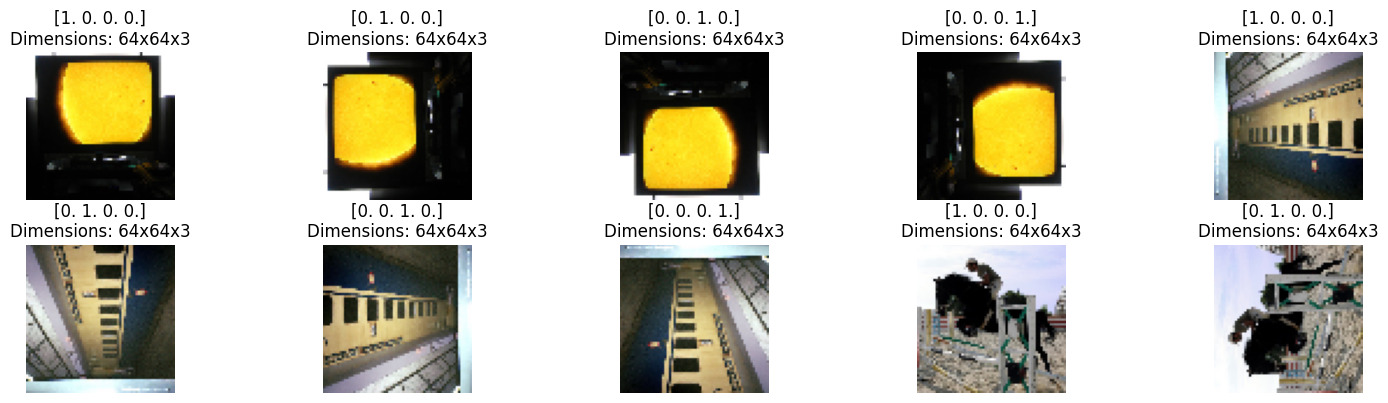

In [ ]:
some_indices = range(N_IMAGES_TO_SHOW)
labels = [l for l in train_labels[some_indices]]
images = [i for i in train_images[some_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'Label: {labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

In [ ]:
# Generate a random permutation of indices to shuffle once the data
shuffled_indices = np.random.permutation(len(train_labels))
train_labels = train_labels[shuffled_indices]
train_images = train_images[shuffled_indices]

### Validation set

In [ ]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [ ]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [ ]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [ ]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 64, 64, 3)

In [ ]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.05282609164714813 GB


In [ ]:
rotated_val=[]
rotated_val_y=[]
i=0
for i in tqdm(range(validation_images.shape[0])):


    for j in range(4):
        if j==0:
            rotated = validation_images[i]#not really rotated
        else:
            rotated = np.rot90(rotated)

        rotated_val.append(rotated)
        rotated_val_y.append(j)

validation_images = np.array(rotated_val)
validation_labels = one_hot_encode(np.array(rotated_val_y), 4)
rotated_val=0 #to free up space

100%|██████████| 1154/1154 [00:00<00:00, 35827.26it/s]


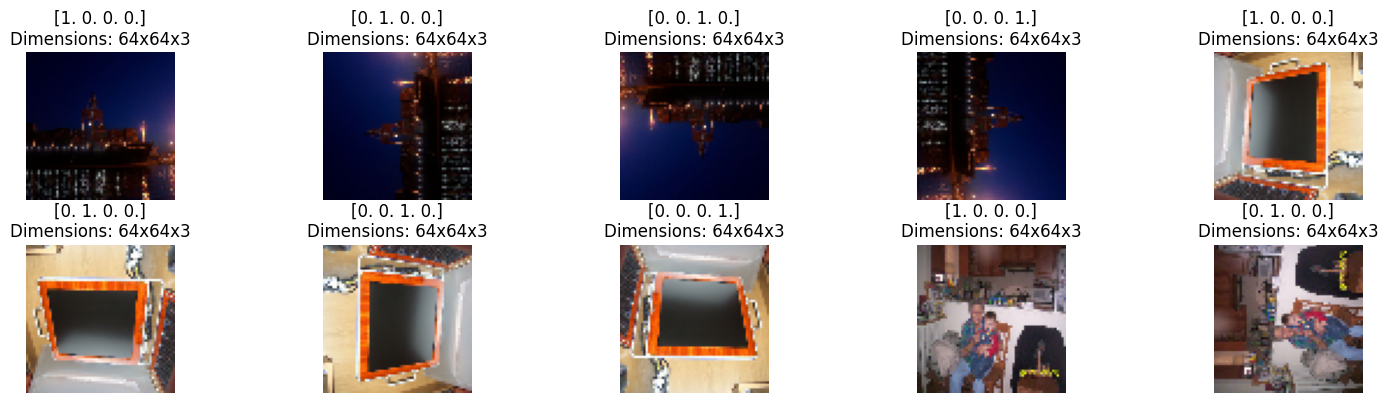

In [ ]:
some_indices = range(N_IMAGES_TO_SHOW)
labels = [l for l in validation_labels[some_indices]]
images = [i for i in validation_images[some_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## training the model on rotation classification task

In [ ]:
from tensorflow.keras.metrics import AUC

def create_base_model(input_shape=(64, 64, 3), num_classes=4, dropout_rate=0.3, model_name="baseline_ssl_model", load_model=True):
    if load_model:
        return tf.keras.models.load_model(f"{model_name}a.keras")


    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(32, activation='relu', kernel_initializer="HeNormal"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ], name=model_name)

    # Mean Average Precision (mAP) usando AUC con curva Precision-Recall
    map_metric = AUC(
        curve='PR',  # Precision-Recall curve
        multi_label=True,
        name='mAP'
    )

    # Top-3 Accuracy
    top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3,
        name='top_3_accuracy'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            top_3_accuracy,
            map_metric
        ]
    )

    return model

model = create_base_model(input_shape=(64, 64, 3))
model.summary()

Model: "baseline_ssl_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 696,270 (2.66 MB)

 Trainable params: 231,876 (905.77 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 463,754 (1.77 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
early_stopping

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_ssl_model_epoch_{epoch:02d}.keras',
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True
    )

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

(36928, 64, 64, 3)
(36928, 4)
(4616, 64, 64, 3)
(4616, 4)


In [ ]:
history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.3016 - loss: 0.5928 - mAP: 0.2912 - top_3_accuracy: 0.7793 - val_accuracy: 0.4127 - val_loss: 0.5213 - val_mAP: 0.4671 - val_top_3_accuracy: 0.8107
Epoch 2/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.3748 - loss: 0.5320 - mAP: 0.4179 - top_3_accuracy: 0.8101 - val_accuracy: 0.4118 - val_loss: 0.5381 - val_mAP: 0.4696 - val_top_3_accuracy: 0.8289
Epoch 3/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4075 - loss: 0.5134 - mAP: 0.4590 - top_3_accuracy: 0.8192 - val_accuracy: 0.4523 - val_loss: 0.5172 - val_mAP: 0.5140 - val_top_3_accuracy: 0.8304
Epoch 4/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4244 - loss: 0.5093 - mAP: 0.4719 - top_3_accuracy: 0.8246 - val_accuracy: 0.4396 - val_loss: 0.5187 - val_mAP: 0.5005 - val_top_3_accuracy: 0.8321
Epoch 5/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4333 - loss: 0.5038 - mAP: 0.4857 - top_3_accuracy: 0.830

In [ ]:
model.save(f"{model.name}.keras")

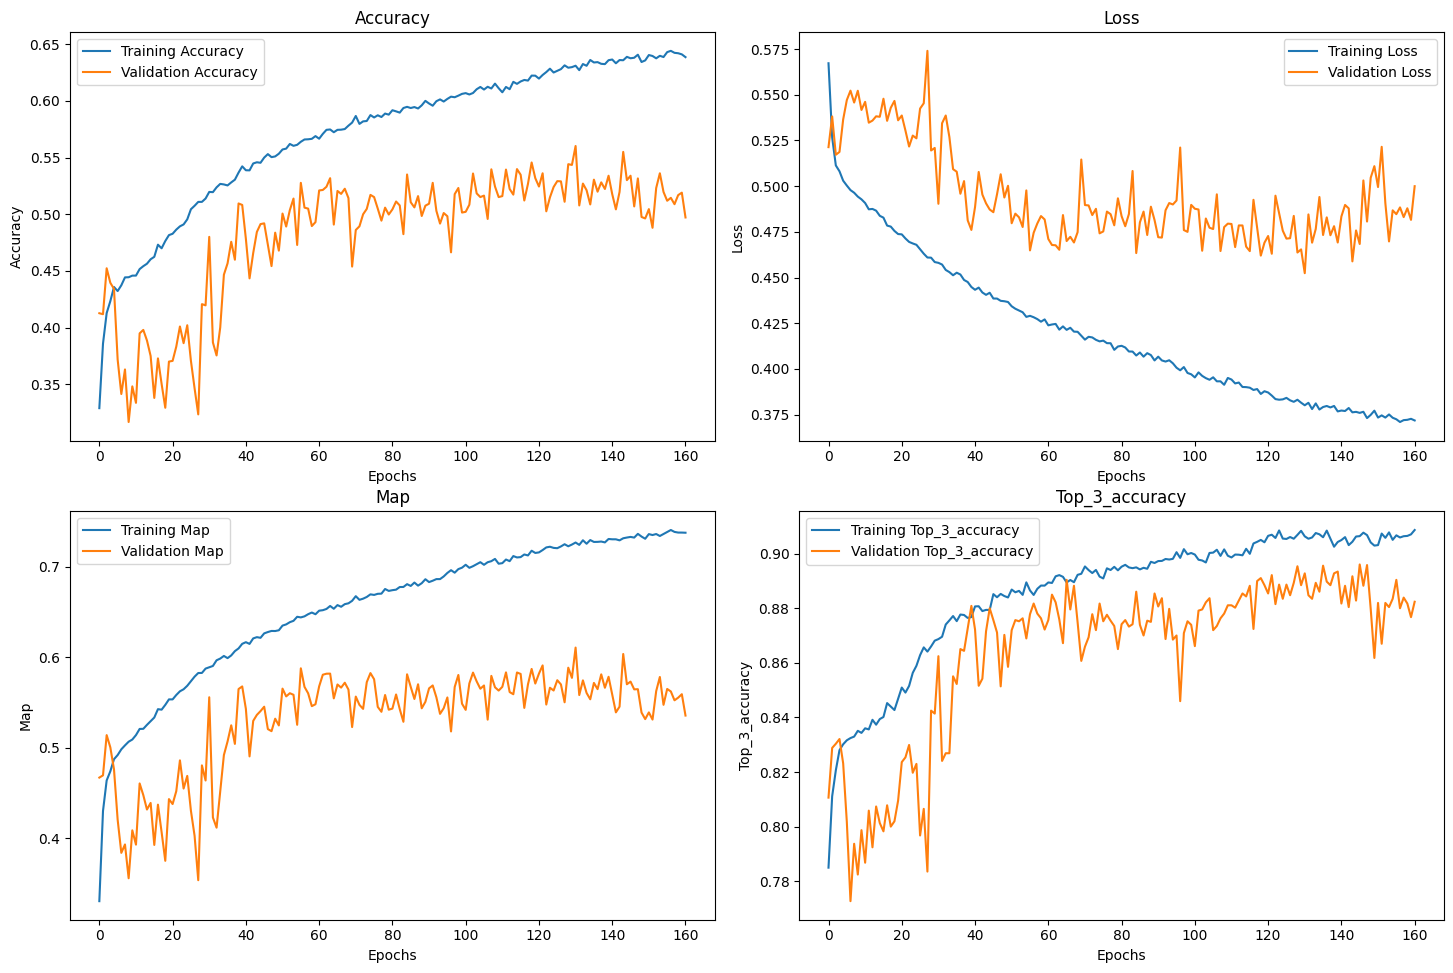

In [ ]:
plot_history(history)

# Loading raw photos and finetuning

## Training set

In [ ]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '../dataset/compressed/train.npz' with keys: images, labels

In [ ]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [ ]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [ ]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 64, 64, 3)

In [ ]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 0.42260758578777313 GB


Labels encoding:

In [ ]:
train_labels = train_data['labels']
train_labels.shape

(9232,)

In [ ]:
print(f'Size of train labels before encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels before encoding: 0.0706024169921875 MB


In [ ]:
encoded_train_labels = np.array([vector_encoding(l, N_CLASSES) for l in train_labels])
encoded_train_labels.shape, encoded_train_labels[0], train_labels[0]

((9232, 20),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 ['tvmonitor'])

In [ ]:
print(f'Size of train labels after encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels after encoding: 0.0706024169921875 MB


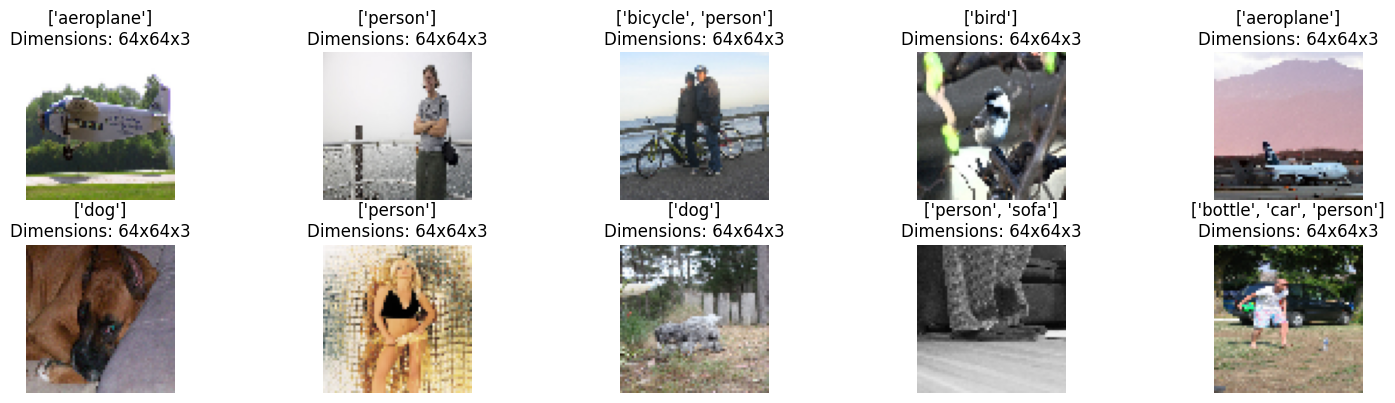

In [ ]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(train_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in train_labels[random_indices]]
images = [i for i in train_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## Validation set

In [ ]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '../dataset/compressed/validation.npz' with keys: images, labels

In [ ]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [ ]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [ ]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 64, 64, 3)

In [ ]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [ ]:
validation_labels = validation_data['labels']
validation_labels.shape

(1154,)

In [ ]:
encoded_validation_labels = np.array([vector_encoding(l, N_CLASSES) for l in validation_labels])
encoded_validation_labels.shape, encoded_validation_labels[0], validation_labels[0]

((1154, 20),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 ['boat'])

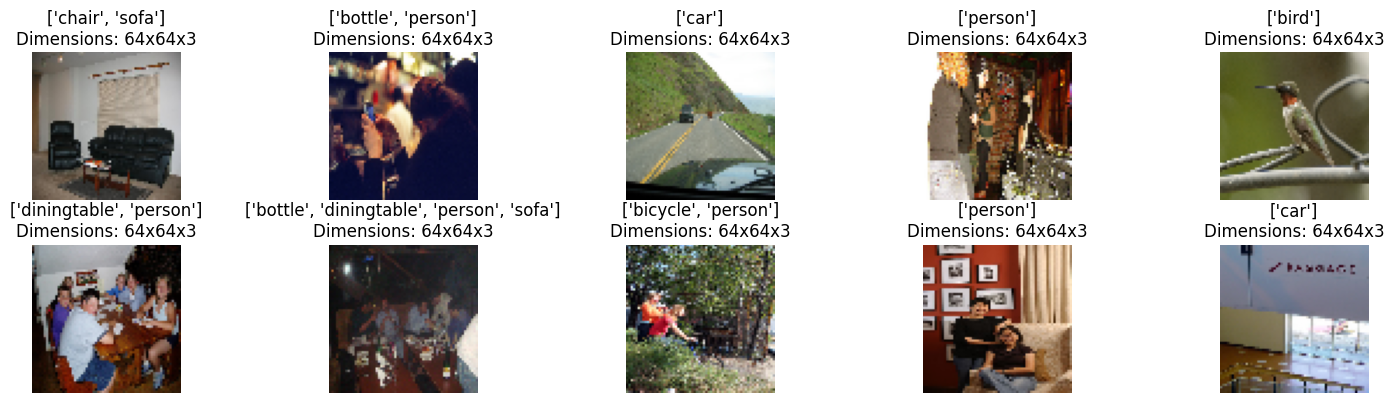

In [ ]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(validation_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in validation_labels[random_indices]]
images = [i for i in validation_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## supervised finetuning

In [ ]:
a=model.layers[-1]

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model(f"{model.name}.keras")

for layer in model.layers:
    layer.trainable=False

model.pop()
model.add(layers.Dense(20, activation='sigmoid') )

model.layers[-1].trainable=True
model.layers[-2].trainable=True
model.layers[-3].trainable=True
model.layers[-4].trainable=True

#model.layers[-1] = layers.Dense(20, activation='sigmoid')


# Mean Average Precision (mAP) usando AUC con curva Precision-Recall
map_metric = AUC(
    curve='PR',  # Precision-Recall curve
    multi_label=True,
    name='mAP'
)

# Top-3 Accuracy
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
    k=3,
    name='top_3_accuracy'
)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        top_3_accuracy,
        map_metric
    ]
)


# Fix possible problems with new model
model.save('temp.keras')
model = tf.keras.models.load_model('temp.keras')


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
encoded_validation_labels.shape

(1154, 20)

In [ ]:
history = model.fit(
    train_images,
    encoded_train_labels,
    validation_data=(validation_images, encoded_validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1271 - loss: 0.3586 - mAP: 0.0763 - top_3_accuracy: 0.2795 - val_accuracy: 0.1326 - val_loss: 0.2653 - val_mAP: 0.0802 - val_top_3_accuracy: 0.2990
Epoch 2/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.1333 - loss: 0.3155 - mAP: 0.0782 - top_3_accuracy: 0.3114 - val_accuracy: 0.1326 - val_loss: 0.2529 - val_mAP: 0.0844 - val_top_3_accuracy: 0.3128
Epoch 3/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1367 - loss: 0.2875 - mAP: 0.0780 - top_3_accuracy: 0.3338 - val_accuracy: 0.1326 - val_loss: 0.2473 - val_mAP: 0.0863 - val_top_3_accuracy: 0.3371
Epoch 4/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.1370 - loss: 0.2743 - mAP: 0.0815 - top_3_accuracy: 0.3400 - val_accuracy: 0.1326 - val_loss: 0.2436 - val_mAP: 0.0871 - val_top_3_accuracy: 0.3536
Epoch 5/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.1377 - loss: 0.2636 - mAP: 0.0822 - top_3_accuracy: 0.3448 - va

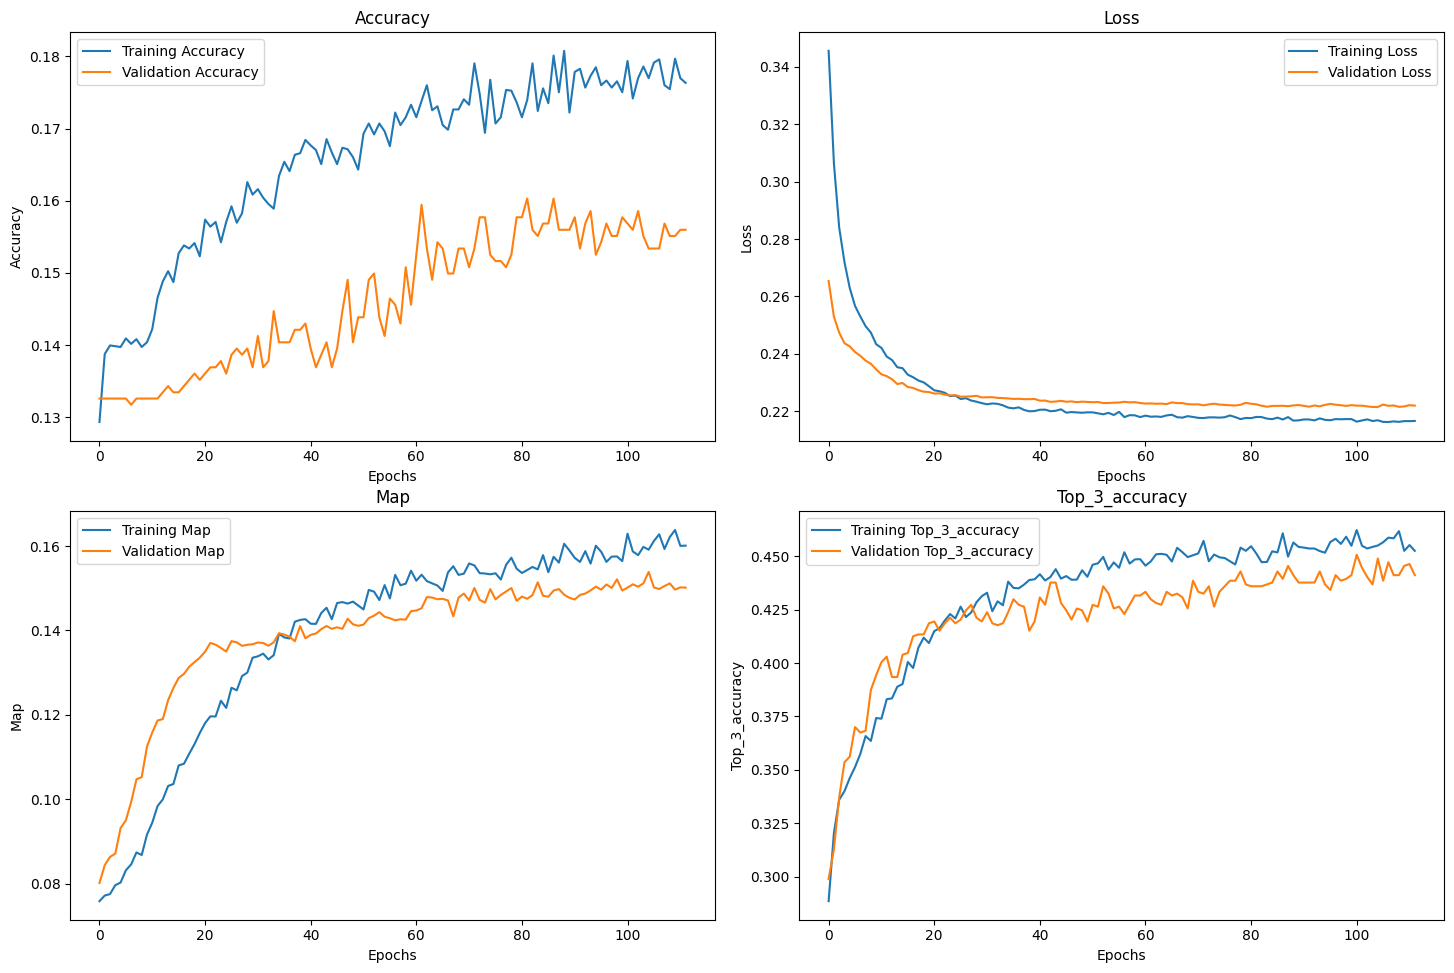

In [ ]:
plot_history(history)

In [ ]:
model.save(f"{model.name}_finetuned.keras")

# Test

### loading Test set

In [ ]:
test_data = np.load(TEST_PATH, allow_pickle=True)
test_data

NpzFile '../dataset/compressed/test.npz' with keys: images, labels

In [ ]:
test_images = test_data['images']
test_images.shape

(1154, 227, 227, 3)

In [ ]:
print(f'Size of test images before preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [ ]:
test_images = preprocess_images(test_images)
test_images.shape

(1154, 64, 64, 3)

In [ ]:
print(f'Size of test images after preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [ ]:
test_labels = test_data['labels']
test_labels.shape

(1154,)

In [ ]:
encoded_test_labels = np.array([vector_encoding(l, N_CLASSES) for l in test_labels])
encoded_test_labels.shape, encoded_test_labels[0], test_labels[0]

((1154, 20),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 ['bottle', 'person', 'tvmonitor'])

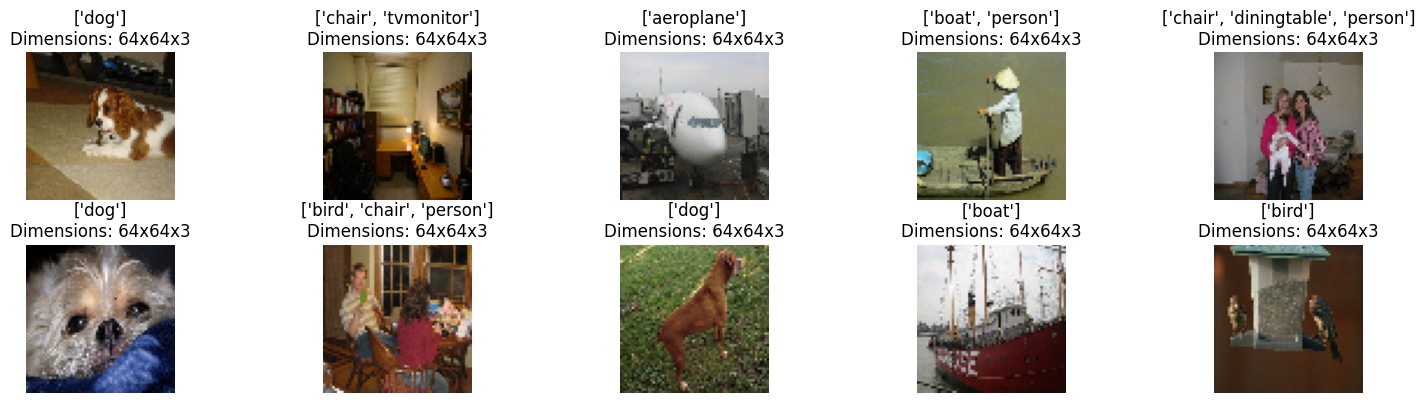

In [ ]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(test_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in test_labels[random_indices]]
images = [i for i in test_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## predict on testset

In [ ]:
y_pred = model.predict(test_images)

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


In [ ]:
accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
accuracy.update_state(encoded_test_labels, y_pred)

accuracy.result().numpy()

0.15511265

In [ ]:
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_3_accuracy.update_state(encoded_test_labels, y_pred)

top_3_accuracy.result().numpy()

0.4254766

In [ ]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.15350862

In [ ]:
metrics = {
    'Accuracy': accuracy.result().numpy(),
    'Top-3 Accuracy': top_3_accuracy.result().numpy(),
    'mAP': map_metric.result().numpy()
}

metrics

{'Accuracy': 0.15511265, 'Top-3 Accuracy': 0.4254766, 'mAP': 0.15350862}